In [ ]:
# Object Counting dengan Morphological Snakes
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import io, color, exposure, filters, measure, morphology, segmentation, util
from skimage.morphology import disk
from skimage.segmentation import (morphological_chan_vese,
                                 morphological_geodesic_active_contour,
                                 inverse_gaussian_gradient,
                                 checkerboard_level_set)
import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display, clear_output
import os
import glob
from PIL import Image
import io as bio_io

# Widget untuk mengunggah gambar
def create_upload_widget():
    upload_widget = widgets.FileUpload(
        accept='.jpg, .jpeg, .png, .bmp, .gif, image/*',
        multiple=True,
        description='Pilih Gambar:'
    )
    return upload_widget

# Fungsi untuk menampilkan gambar
def display_images(images, titles=None, cmaps=None, figsize=(16, 8)):
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(n_images)]
    if cmaps is None: cmaps = ['viridis' for i in range(n_images)]

    fig, axes = plt.subplots(1, n_images, figsize=figsize)
    if n_images == 1:
        axes = [axes]

    for i, (image, title, cmap) in enumerate(zip(images, titles, cmaps)):
        axes[i].imshow(image, cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Fungsi untuk melakukan preprocessing pada gambar
def preprocess_image(image, preprocessing_method='adaptive_histogram'):
    if len(image.shape) > 2 and image.shape[2] == 3:  # Jika RGB
        gray_img = color.rgb2gray(image)
    else:
        gray_img = image

    if preprocessing_method == 'adaptive_histogram':
        processed = exposure.equalize_adapthist(gray_img)
    elif preprocessing_method == 'histogram_equalization':
        processed = exposure.equalize_hist(gray_img)
    elif preprocessing_method == 'contrast_stretching':
        p2, p98 = np.percentile(gray_img, (2, 98))
        processed = exposure.rescale_intensity(gray_img, in_range=(p2, p98))
    elif preprocessing_method == 'median_filter':
        # Pastikan disk radius adalah integer
        processed = filters.median(gray_img, disk(int(3)))
    elif preprocessing_method == 'gaussian_filter':
        processed = filters.gaussian(gray_img, sigma=1.0)
    else:
        processed = gray_img

    return processed

# Fungsi untuk inisialisasi level set
def initialize_level_set(image, method='checkerboard'):
    if method == 'checkerboard':
        init_ls = checkerboard_level_set(image.shape, 6)
    elif method == 'circle':
        init_ls = np.zeros(image.shape)
        # Pastikan slice menggunakan integer
        h, w = image.shape
        init_ls[int(10):h-int(10), int(10):w-int(10)] = 1
    elif method == 'random':
        init_ls = np.random.random(image.shape) > 0.5
    else:
        init_ls = checkerboard_level_set(image.shape, 6)

    return init_ls

# Fungsi untuk melakukan segmentasi dengan morphological snakes
def segment_with_morphsnakes(image, method='MorphGAC', iterations=100, smoothing=1, threshold=0.3, init_level_set_method='checkerboard'):
    # Konversi parameter ke integer jika diperlukan
    iterations = int(iterations)
    smoothing = int(smoothing)  # Konversi smoothing ke integer

    # Preprocessing untuk Morphological Geodesic Active Contour
    if method == 'MorphGAC':
        gimage = inverse_gaussian_gradient(image)
        init_ls = initialize_level_set(image, method=init_level_set_method)
        segmented = morphological_geodesic_active_contour(gimage, iterations,
                                                         init_level_set=init_ls,
                                                         smoothing=smoothing,
                                                         threshold=threshold)

    # Morphological Chan-Vese
    elif method == 'MorphCV':
        init_ls = initialize_level_set(image, method=init_level_set_method)
        segmented = morphological_chan_vese(image, iterations,
                                           init_level_set=init_ls,
                                           smoothing=smoothing)

    # Watershed
    elif method == 'Watershed':
        # Identify markers for watershed
        edges = filters.sobel(image)
        markers = np.zeros_like(image, dtype=int)
        foreground_threshold = filters.threshold_otsu(image)
        markers[image < foreground_threshold/2] = 1
        markers[image > foreground_threshold*2] = 2
        segmented = segmentation.watershed(edges, markers)
        segmented = segmented > 1

    # Otsu thresholding
    elif method == 'Otsu':
        thresh_value = filters.threshold_otsu(image)
        segmented = image > thresh_value

    # Otsu thresholding with morphological operations
    elif method == 'Otsu+Morph':
        thresh_value = filters.threshold_otsu(image)
        segmented = image > thresh_value
        segmented = morphology.remove_small_holes(segmented, area_threshold=50)
        segmented = morphology.remove_small_objects(segmented, min_size=50)

    else:
        # Default to MorphCV if method not recognized
        init_ls = initialize_level_set(image, method=init_level_set_method)
        segmented = morphological_chan_vese(image, iterations,
                                           init_level_set=init_ls,
                                           smoothing=smoothing)

    return segmented

# Fungsi untuk menghitung objek
def count_objects(binary_image):
    # Melakukan labeling pada objek yang tersegmentasi
    labeled_image, num_features = ndi.label(binary_image)

    # Menghitung properti dari objek yang terdeteksi
    regions = measure.regionprops(labeled_image)

    # Filter objek berdasarkan ukuran (opsional)
    filtered_regions = [region for region in regions if region.area >= 50]

    # Membuat gambar dengan label untuk visualisasi
    label_image = np.zeros_like(binary_image, dtype=int)
    for i, region in enumerate(filtered_regions):
        label_image[labeled_image == region.label] = i + 1

    return label_image, len(filtered_regions)

# Fungsi untuk memproses gambar dan menampilkan hasil
def process_image(image_data, preprocessing_method='adaptive_histogram',
                 segmentation_method='MorphCV', iterations=100,
                 smoothing=1, threshold=0.3, init_level_set_method='checkerboard'):

    # Preprocessing gambar
    preprocessed = preprocess_image(image_data, preprocessing_method)

    # Segmentasi menggunakan morphological snakes
    segmented = segment_with_morphsnakes(preprocessed, method=segmentation_method,
                                        iterations=iterations, smoothing=smoothing,
                                        threshold=threshold,
                                        init_level_set_method=init_level_set_method)

    # Menghitung objek
    labeled_image, num_objects = count_objects(segmented)

    # Menampilkan hasil
    display_images([image_data, preprocessed, segmented, labeled_image],
                  titles=['Gambar Asli', 'Preprocessed', 'Segmented', f'Objects: {num_objects}'],
                  cmaps=['gray', 'gray', 'gray', 'nipy_spectral'])

    print(f"Jumlah objek yang terdeteksi: {num_objects}")

    return preprocessed, segmented, labeled_image, num_objects

# Fungsi untuk membuat kontrol interaktif
def create_interactive_controls(image, filename):
    # Menampilkan gambar asli
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Gambar Asli: {filename}")
    plt.axis('off')
    plt.show()

    # Membuat widget interaktif untuk memproses gambar
    preprocessing_dropdown = widgets.Dropdown(
        options=['adaptive_histogram', 'histogram_equalization', 'contrast_stretching', 'median_filter', 'gaussian_filter', 'none'],
        value='adaptive_histogram',
        description='Preprocessing:'
    )

    segmentation_dropdown = widgets.Dropdown(
        options=['MorphCV', 'MorphGAC', 'Watershed', 'Otsu', 'Otsu+Morph'],
        value='MorphCV',
        description='Segmentasi:'
    )

    iterations_slider = widgets.IntSlider(
        value=100,
        min=10,
        max=300,
        step=10,
        description='Iterasi:'
    )

    smoothing_slider = widgets.IntSlider(  # Mengubah FloatSlider menjadi IntSlider
        value=1,
        min=1,
        max=5,
        step=1,
        description='Smoothing:'
    )

    threshold_slider = widgets.FloatSlider(
        value=0.3,
        min=0.1,
        max=0.9,
        step=0.05,
        description='Threshold:'
    )

    init_level_set_dropdown = widgets.Dropdown(
        options=['checkerboard', 'circle', 'random'],
        value='checkerboard',
        description='Initial LS:'
    )

    # Membuat fungsi untuk menjalankan pemrosesan saat parameter diubah
    def update_processing(preprocessing, segmentation, iterations, smoothing, threshold, init_level_set):
        clear_output(wait=True)

        # Menampilkan gambar asli
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Gambar Asli: {filename}")
        plt.axis('off')
        plt.show()

        # Memproses gambar dengan parameter terbaru
        process_image(image, preprocessing_method=preprocessing,
                     segmentation_method=segmentation,
                     iterations=iterations,
                     smoothing=smoothing,
                     threshold=threshold,
                     init_level_set_method=init_level_set)

    # Membuat widget interaktif
    interactive_widget = interact(update_processing,
                                 preprocessing=preprocessing_dropdown,
                                 segmentation=segmentation_dropdown,
                                 iterations=iterations_slider,
                                 smoothing=smoothing_slider,
                                 threshold=threshold_slider,
                                 init_level_set=init_level_set_dropdown)

# Fungsi untuk memproses gambar yang diunggah
def process_uploaded_images(change, upload_widget):
    if upload_widget is None or not upload_widget.value:
        print("Tidak ada gambar yang diunggah.")
        return

    uploaded_files = list(upload_widget.value.items())

    # Menampilkan panel interaktif untuk setiap gambar
    for i, (filename, file_info) in enumerate(uploaded_files):
        print(f"\nMemproses gambar {i+1}/{len(uploaded_files)}: {filename}")

        # Membaca gambar dari konten yang diunggah
        try:
            # Mendeteksi format file dari ekstensi
            file_ext = os.path.splitext(filename)[1].lower()

            # Membaca gambar menggunakan metode yang sesuai
            content_io = bio_io.BytesIO(file_info['content'])
            try:
                # Menggunakan PIL untuk membaca file - lebih reliable untuk berbagai format
                img = Image.open(content_io)
                image = np.array(img)
            except Exception as img_error:
                print(f"Error membaca gambar dengan PIL: {str(img_error)}")
                # Mencoba metode alternatif jika PIL gagal
                try:
                    content_io.seek(0)  # Reset posisi file
                    image = plt.imread(content_io)
                except Exception as plt_error:
                    raise Exception(f"Gagal membaca file gambar: {str(img_error)} & {str(plt_error)}")

            # Pastikan gambar grayscale memiliki bentuk yang benar
            if len(image.shape) == 2:
                # Gambar sudah grayscale
                pass
            elif len(image.shape) == 3 and image.shape[2] == 4:
                # Gambar RGBA, konversi ke RGB
                image = color.rgba2rgb(image)

            # Menampilkan kontrol interaktif untuk gambar ini
            create_interactive_controls(image, filename)

        except Exception as e:
            print(f"Error memproses gambar {filename}: {str(e)}")
            continue



Memproses gambar 1/2: neuron.jpg


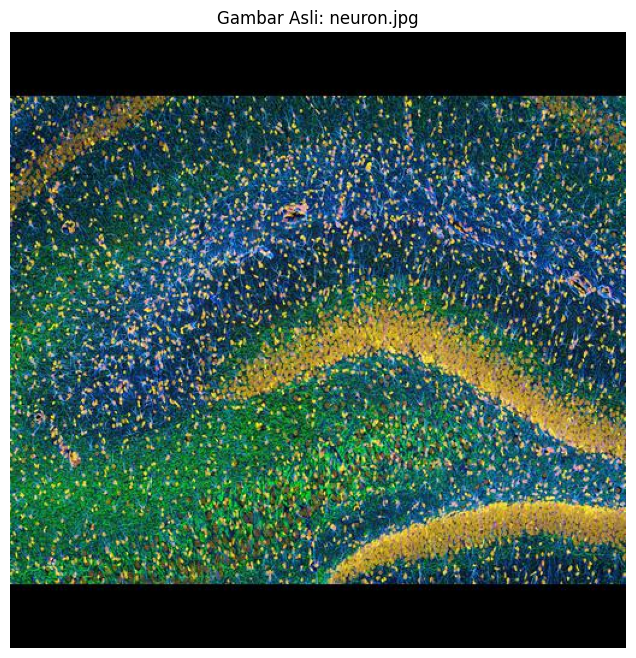

interactive(children=(Dropdown(description='Preprocessing:', options=('adaptive_histogram', 'histogram_equaliz…


Memproses gambar 2/2: forest.jpg


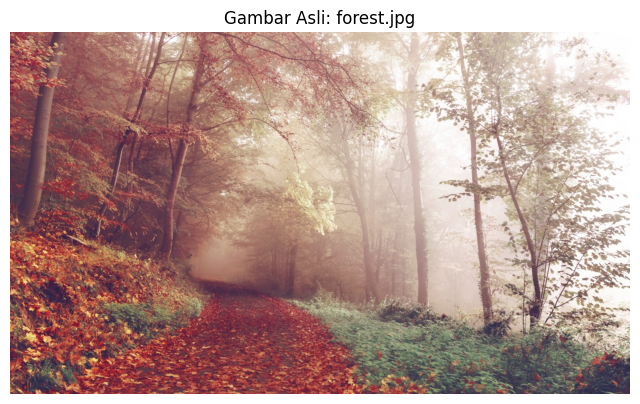

interactive(children=(Dropdown(description='Preprocessing:', options=('adaptive_histogram', 'histogram_equaliz…

In [ ]:
upload_widget = create_upload_widget()

# Membuat tombol proses
process_button = widgets.Button(
  description='Proses Gambar',
  button_style='success',
  tooltip='Klik untuk memproses gambar yang diunggah'
)

# Mendefinisikan fungsi onclick untuk tombol proses
def on_process_button_clicked(b):
  process_uploaded_images(None, upload_widget)

# Menambahkan event handler untuk tombol
process_button.on_click(on_process_button_clicked)

# Menampilkan widget upload dan tombol proses
display(widgets.VBox([upload_widget, process_button]))